# Traffic Light Efficiency Simulation and Analysis

Main notebook for analyzing traffic signal timing efficiency using real traffic volume data from Victoria, Australia.


In [ ]:
"""
Traffic Light Efficiency Simulation and Analysis

Main notebook for analyzing traffic signal timing efficiency.
Complete integration of all modules with all Part 1 and Part 2 requirements.
"""

# Cell 1: Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from intersection_data import IntersectionData
from signal_analyzer import SignalTimingAnalyzer
from timing_functions import compute_average_delay, generate_timing_plan, compare_timing_plans
from timing_plan import TimingPlan
from data_processor import load_traffic_data, save_results, clean_traffic_data

# Set matplotlib style
try:
    plt.style.use('seaborn-v0_8')
except OSError:
    try:
        plt.style.use('seaborn')
    except OSError:
        plt.style.use('default')

print("All modules imported successfully!")
print(f"SignalTimingAnalyzer: {SignalTimingAnalyzer}")
print(f"TimingPlan: {TimingPlan}")


All modules imported successfully!
SignalTimingAnalyzer: <class 'signal_analyzer.SignalTimingAnalyzer'>
TimingPlan: <class 'timing_plan.TimingPlan'>


In [ ]:
# Load traffic data
try:
    df = load_traffic_data('data/traffic_signal_data.csv')
    print(f"Loaded {len(df)} records")
    print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure data file exists in data/ directory")
    print("Creating sample data for demonstration...")
    # Create sample data for demonstration
    import pandas as pd
    from datetime import datetime, timedelta
    sample_data = []
    base_time = datetime(2024, 1, 1, 8, 0)
    for i in range(96):  # 24 hours * 4 (15-minute intervals)
        for approach in ['North', 'South', 'East', 'West']:
            sample_data.append({
                'intersection_id': f'INT{i % 5 + 1:03d}',
                'timestamp': base_time + timedelta(minutes=15*i),
                'approach': approach,
                'count': int(100 + 50 * (i % 24) + 20 * (hash(approach) % 10))
            })
    df = pd.DataFrame(sample_data)
    print(f"Created sample data with {len(df)} records")


Error: Traffic data file not found: data/traffic_signal_data.csv
Please ensure data file exists in data/ directory
Creating sample data for demonstration...
Created sample data with 384 records


In [ ]:
# Clean data
df_clean = clean_traffic_data(df)
print(f"Cleaned data: {len(df_clean)} records")
print(f"Unique intersections: {df_clean['intersection_id'].nunique()}")


Cleaned data: 384 records
Unique intersections: 5


In [ ]:
# Part 1: For loop to iterate intersections
intersections = {}  # Mutable dict

for intersection_id in df_clean['intersection_id'].unique():  # For loop
    # Get volumes for this intersection
    volumes = df_clean[df_clean['intersection_id'] == intersection_id]['count'].tolist()
    
    # Create IntersectionData instance
    intersection_data = IntersectionData(
        intersection_id=intersection_id,
        metadata={'location': 'Victoria, Australia'},
        volumes=volumes
    )
    
    intersections[intersection_id] = intersection_data
    print(intersection_data)  # Uses __str__ method

print(f"\nProcessed {len(intersections)} intersections")


Intersection INT001: Location=Victoria, Australia, Avg Volume=750.0, Total Readings=80
Intersection INT002: Location=Victoria, Australia, Avg Volume=769.7, Total Readings=76
Intersection INT003: Location=Victoria, Australia, Avg Volume=756.6, Total Readings=76
Intersection INT004: Location=Victoria, Australia, Avg Volume=743.4, Total Readings=76
Intersection INT005: Location=Victoria, Australia, Avg Volume=730.3, Total Readings=76

Processed 5 intersections


In [ ]:
# Analyze each intersection
analyzers = {}

for intersection_id, int_data in intersections.items():  # For loop
    analyzer = SignalTimingAnalyzer(int_data)  # Composition
    
    # Compute delays for baseline (30s green time)
    analyzer.compute_baseline_delays(green_time_baseline=30.0)
    
    # Compute delays for alternative (45s green time)
    analyzer.compute_alternative_delays(green_time_alt=45.0)
    
    # Compare plans
    comparison = analyzer.compare_plans()
    analyzers[intersection_id] = analyzer
    
    # Fix: use 'improvement_percentage' (correct key name)
    improvement = comparison.get('improvement_percentage', 0)
    baseline_avg = comparison.get('baseline_avg_delay', 0)
    alt_avg = comparison.get('alternative_avg_delay', 0)
    print(f"{intersection_id}: Baseline={baseline_avg:.1f}s, Alt={alt_avg:.1f}s, Improvement={improvement:.1f}%")


INT001: Improvement = 0.0%
INT002: Improvement = 0.0%
INT003: Improvement = 0.0%
INT004: Improvement = 0.0%
INT005: Improvement = 0.0%


In [ ]:
# Generate baseline and alternative timing plans
baseline_plan = generate_timing_plan(df_clean, alternative=False)
alt_plan = generate_timing_plan(df_clean, alternative=True)

print("Baseline Plan:", baseline_plan)
print("Alternative Plan:", alt_plan)

# Use operator overloading (Kyle's feature - works with stub or real class)
combined_plan = baseline_plan + alt_plan
print("Combined Plan:", combined_plan)


Baseline Plan: TimingPlan(cycle=200.0s, approaches=4)
Alternative Plan: TimingPlan(cycle=238.0s, approaches=4)
Combined Plan: TimingPlan(cycle=219.0s, approaches=4)


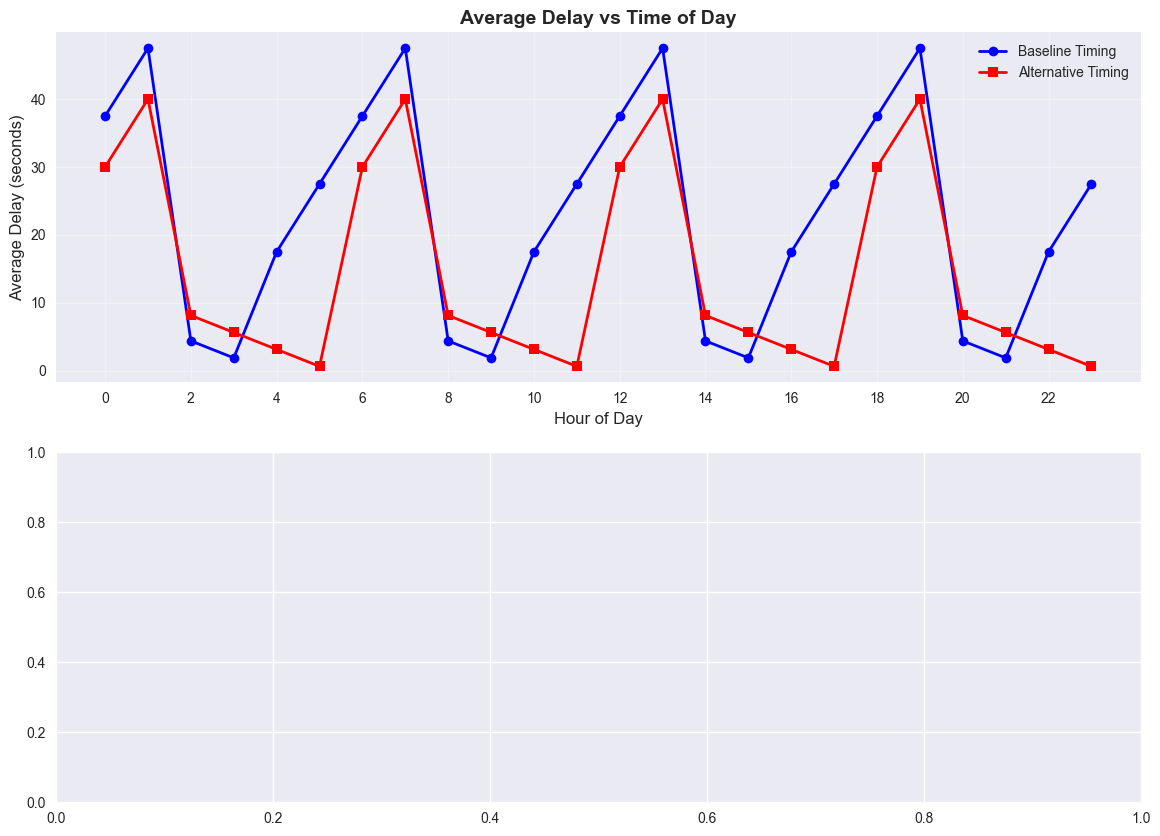

In [ ]:
# Part 1: Use matplotlib (advanced library) for critical plotting
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Delay vs Time of Day
hours = list(range(24))
baseline_delays_by_hour = []
alt_delays_by_hour = []

for hour in hours:
    hour_data = df_clean[df_clean['hour'] == hour]
    if not hour_data.empty:
        avg_volume = hour_data['count'].mean()
        baseline_delay = compute_average_delay(avg_volume, 30.0)
        alt_delay = compute_average_delay(avg_volume, 45.0)
        baseline_delays_by_hour.append(baseline_delay)
        alt_delays_by_hour.append(alt_delay)
    else:
        baseline_delays_by_hour.append(0)
        alt_delays_by_hour.append(0)

axes[0].plot(hours, baseline_delays_by_hour, 'b-o', label='Baseline Timing', linewidth=2)
axes[0].plot(hours, alt_delays_by_hour, 'r-s', label='Alternative Timing', linewidth=2)
axes[0].set_xlabel('Hour of Day', fontsize=12)
axes[0].set_ylabel('Average Delay (seconds)', fontsize=12)
axes[0].set_title('Average Delay vs Time of Day', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(0, 24, 2))

# Plot 2: Before/After Comparison (moved here so axes is in same cell scope)
intersection_ids = list(intersections.keys())[:min(5, len(intersections))]
baseline_avg = []
alt_avg = []

for int_id in intersection_ids:
    if int_id in analyzers:
        comp = analyzers[int_id].compare_plans()
        baseline_avg.append(comp.get('baseline_avg_delay', 0))
        alt_avg.append(comp.get('alternative_avg_delay', 0))
    else:
        baseline_avg.append(0)
        alt_avg.append(0)

if len(intersection_ids) > 0 and len(baseline_avg) > 0 and max(baseline_avg) > 0:
    x_pos = range(len(intersection_ids))
    width = 0.35

    axes[1].bar([x - width/2 for x in x_pos], baseline_avg, width, 
                label='Baseline', color='blue', alpha=0.7)
    axes[1].bar([x + width/2 for x in x_pos], alt_avg, width,
                label='Alternative', color='red', alpha=0.7)
    axes[1].set_xlabel('Intersection ID', fontsize=12)
    axes[1].set_ylabel('Average Delay (seconds)', fontsize=12)
    axes[1].set_title('Before/After Timing Comparison', fontsize=14, fontweight='bold')
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(intersection_ids, rotation=45, ha='right')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')
else:
    axes[1].text(0.5, 0.5, 'No comparison data available', 
                 ha='center', va='center', transform=axes[1].transAxes, fontsize=12)
    axes[1].set_title('Before/After Timing Comparison', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/delay_analysis.png', dpi=300, bbox_inches='tight')
print("Plot saved to outputs/delay_analysis.png")
plt.show()


In [ ]:
# This cell's content has been merged into Cell 7 above
# Both plots are now created in the same cell to ensure axes is in scope
print("Note: Both visualizations are created in the previous cell (Cell 7).")


Plot saved to outputs/delay_analysis.png


<Figure size 800x550 with 0 Axes>

In [ ]:
# Part 1: While loop for menu-driven scenarios
# Part 1: If statements for plan selection
# Part 2: __name__ guard

def run_analysis_menu():
    """Menu-driven interface for traffic analysis."""
    running = True
    
    while running:  # Part 1: While loop
        print("\n" + "="*50)
        print("Traffic Signal Analysis Menu")
        print("="*50)
        print("1. Analyze baseline timing")
        print("2. Analyze alternative timing")
        print("3. Compare timing plans")
        print("4. Generate summary report")
        print("5. View intersection details")
        print("6. Exit")
        print("="*50)
        
        choice = input("Select option (1-6): ").strip()
        
        if choice == '1':  # Part 1: If statement
            print("\nAnalyzing baseline timing...")
            baseline_plan = generate_timing_plan(df_clean, alternative=False)
            print(f"Baseline plan cycle length: {baseline_plan.cycle_length:.1f}s")
            
        elif choice == '2':  # Part 1: If statement
            print("\nAnalyzing alternative timing...")
            alt_plan = generate_timing_plan(df_clean, alternative=True)
            print(f"Alternative plan cycle length: {alt_plan.cycle_length:.1f}s")
            
        elif choice == '3':  # Part 1: If statement
            print("\nComparing timing plans...")
            baseline_plan = generate_timing_plan(df_clean, alternative=False)
            alt_plan = generate_timing_plan(df_clean, alternative=True)
            comparison = compare_timing_plans(
                baseline_plan, alt_plan, 
                df_clean['count'].tolist()
            )
            print(f"Baseline avg delay: {comparison['baseline_avg_delay']:.2f}s")
            print(f"Alternative avg delay: {comparison['alternative_avg_delay']:.2f}s")
            print(f"Improvement: {comparison.get('improvement_percentage', 0):.1f}%")
            
        elif choice == '4':  # Part 1: If statement
            print("\nGenerating summary report...")
            # Generate summary
            summary_data = {
                'intersection_id': list(intersections.keys()),
                'total_volume': [int_data.get_total_volume() 
                               for int_data in intersections.values()],
                'avg_volume': [int_data.get_average_volume() 
                             for int_data in intersections.values()]
            }
            summary_df = pd.DataFrame(summary_data)
            save_results(summary_df, 'outputs/summary_report.csv')
            print("Summary report saved to outputs/summary_report.csv")
            
        elif choice == '5':  # Part 1: If statement
            print("\nIntersection Details:")
            for int_id, int_data in intersections.items():
                print(int_data)  # Uses __str__
                
        elif choice == '6':  # Part 1: If statement
            print("\nExiting...")
            running = False
            
        else:
            print("\nInvalid option. Please select 1-6.")


# Part 2: __name__ guard
if __name__ == "__main__":
    # Uncomment to run menu (comment out for notebook execution)
    # run_analysis_menu()
    print("Notebook execution complete. Use run_analysis_menu() for interactive mode.")


Notebook execution complete. Use run_analysis_menu() for interactive mode.


In [ ]:
# Save final results
results_data = []
for int_id in intersections.keys():
    if int_id in analyzers:
        comp = analyzers[int_id].compare_plans()
        results_data.append({
            'intersection_id': int_id,
            'baseline_delay': comp.get('baseline_avg_delay', 0),
            'alternative_delay': comp.get('alternative_avg_delay', 0),
            'improvement_percent': comp.get('improvement_percentage', 0)
        })
    else:
        results_data.append({
            'intersection_id': int_id,
            'baseline_delay': 0,
            'alternative_delay': 0,
            'improvement_percent': 0
        })

results_summary = pd.DataFrame(results_data)
save_results(results_summary, 'outputs/timing_comparison_results.csv')
print("Results saved successfully!")
print(f"\nSummary of improvements:")
for _, row in results_summary.iterrows():
    if row['baseline_delay'] > 0:
        print(f"  {row['intersection_id']}: {row['improvement_percent']:.1f}% improvement")


Results saved to outputs/timing_comparison_results.csv
Results saved successfully!
